In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

#Exploratory Data Analysis

Before beginning in-depth modeling, it's good to get a sense of what our data looks like. Perhaps we can see what variables seem to have relationships with one another which can form a basis for predictive modeling.

##Visualizing the Air Pollutant Data

In [2]:
#Load in the 3 US datasets
YearDat = pd.read_csv('YearDat2.csv')
MonthDat = pd.read_csv('MonthDat2.csv')
SeasonDat = pd.read_csv('SeasonDat2.csv')

One of the best first steps is the get a sense the distribution of the various variables in the dataset. We can start by looking at the distribution of the several pollutants in our dataset to see how they vary by site. To begin with, we can look at distributions of the pollutants through monthly and seasonal time periods.

In [3]:
#Generate a mapper to get Month Labels for plots
mapper = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
MonthDatMapped = MonthDat.copy()
MonthDatMapped['Month']=MonthDatMapped['month'].map(mapper.get)

C:\Users\Mark\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


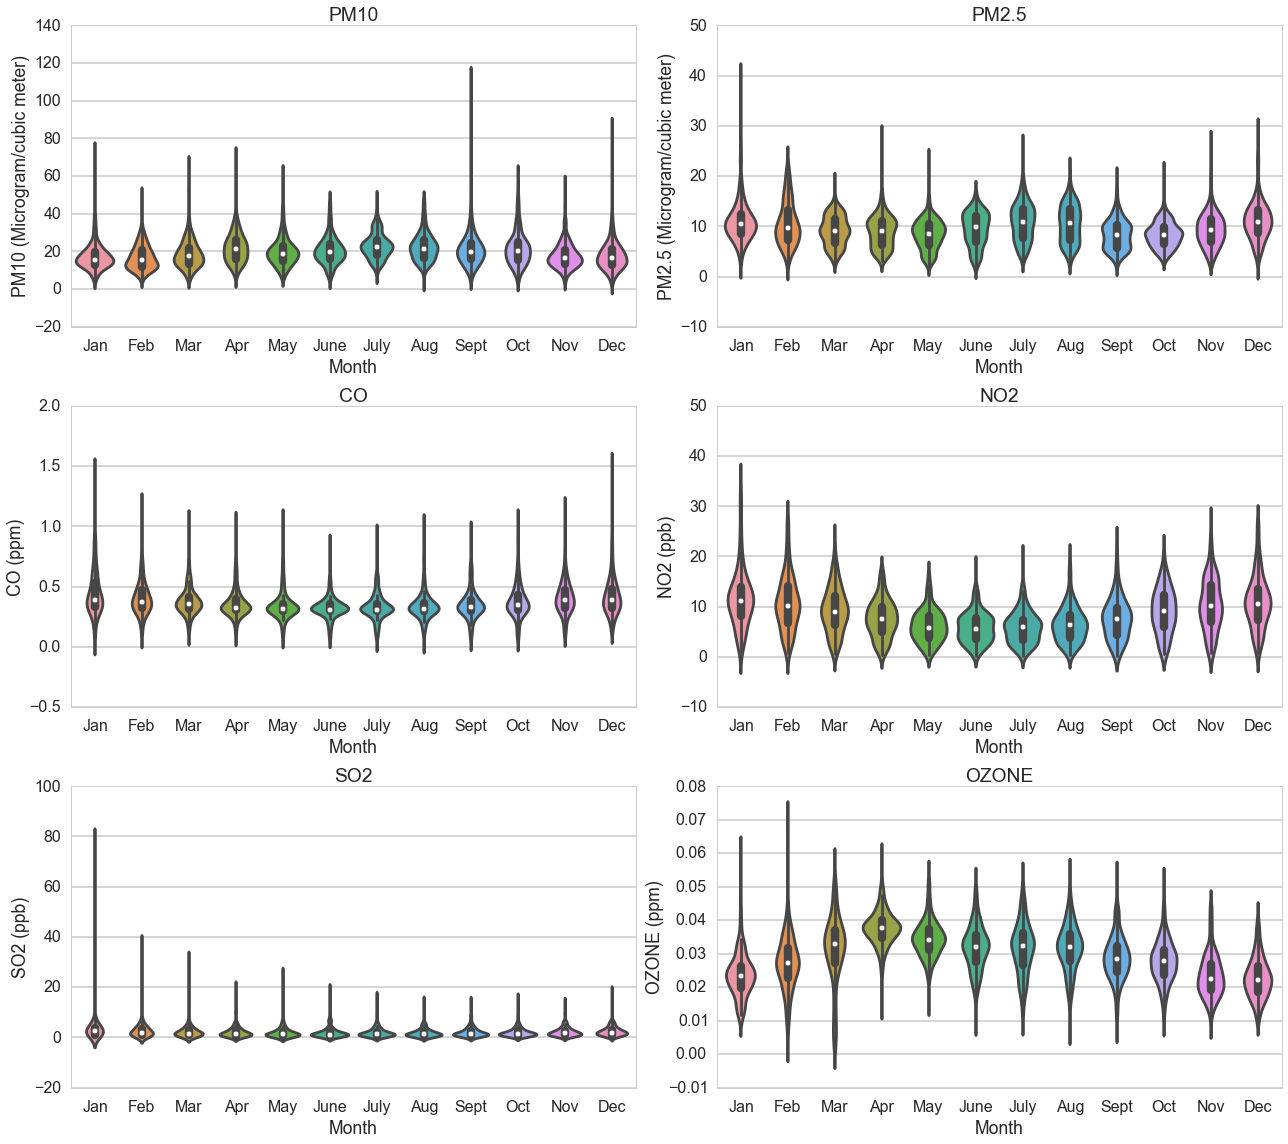

In [4]:
#Create 6 plots, one for each pollutant
#Then make a violin-plot of that pollutant
#for each month
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 16))
fig.set_tight_layout(True)
sns.violinplot(x='Month',y='PM10',data=MonthDatMapped, ax = axes[0,0])
axes[0,0].set_title('PM10')
axes[0,0].set_ylabel('PM10 (Microgram/cubic meter)')
sns.violinplot(x='Month',y='PM25_FRMFEM',data=MonthDatMapped, ax = axes[0,1])
axes[0,1].set_title('PM2.5')
axes[0,1].set_ylabel('PM2.5 (Microgram/cubic meter)')
sns.violinplot(x='Month',y='CO',data=MonthDatMapped, ax = axes[1,0])
axes[1,0].set_title('CO')
axes[1,0].set_ylabel('CO (ppm)')
sns.violinplot(x='Month',y='NO2',data=MonthDatMapped, ax = axes[1,1])
axes[1,1].set_title('NO2')
axes[1,1].set_ylabel('NO2 (ppb)')
sns.violinplot(x='Month',y='SO2',data=MonthDatMapped, ax = axes[2,0])
axes[2,0].set_title('SO2')
axes[2,0].set_ylabel('SO2 (ppb)')
sns.violinplot(x='Month',y='OZONE',data=MonthDatMapped, ax = axes[2,1])
axes[2,1].set_title('OZONE')
axes[2,1].set_ylabel('OZONE (ppm)')

The above plots give us the distribution of each of the six air quality variables, distributed across the months of 2010. There are few takeaways:
1. There are a few outliers throughout the data. For example, there is a very high $SO_2$ value in January of 2010 for one site. This actually corresponds to the Hilo, HI site which is volcanically active. Volcanoes emit large levels of $SO_2$ so this isn't surprising.
2. The general distriubtion of all these metrics remains fairly consistent throughout the year. There are perhaps slight seasonal changes in ozone (smaller in the winter months) and $SO_2$ (larger in the winter months) but they are fairly minor in the grand scheme of things.
3. The variablility of most variables appears somewhat symmetric (perhaps exclusing $SO_2$) which is great for modeling purposes.

We can also look a little more carefully at seasonal trends in the pollutants by looking at barcharts of the pollutants through time.

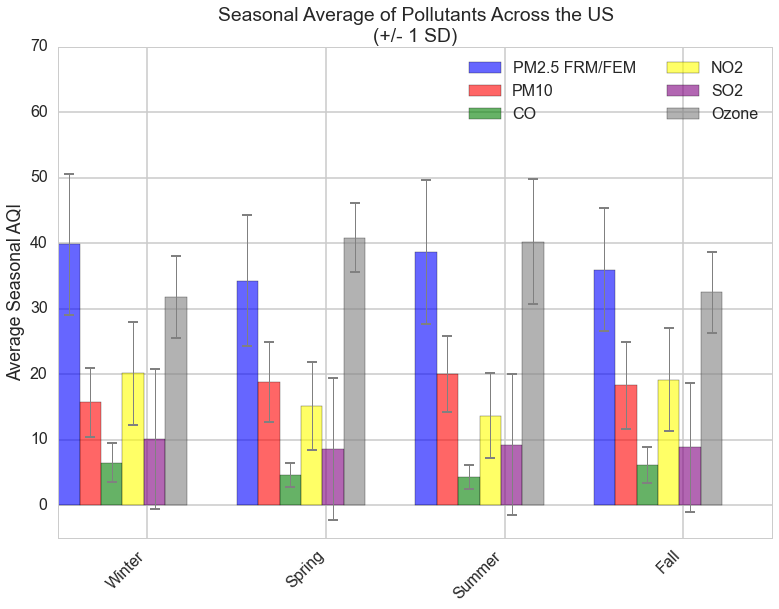

In [5]:
#Visualize the average pollutants by season
#Group by season
group = SeasonDat.groupby('season')
#Get group means and sd
plotVals = group.mean()
plotError = group.std()
#Intiate plots
fig, ax1 = plt.subplots()
#set the x-axis locations
x=[0,1,2,3]
#Plot bars and errors for each pollutant
pm25_bar=plt.bar(x,[float(plotVals[plotVals.index=='Winter']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM25_FRMFEM']),float(plotVals[plotVals.index=='Fall']['AQI_PM25_FRMFEM'])],
                  width=.12,color='blue',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_PM25_FRMFEM']),float(plotError[plotError.index=='Spring']['AQI_PM25_FRMFEM']),
 float(plotError[plotError.index=='Summer']['AQI_PM25_FRMFEM']),float(plotError[plotError.index=='Fall']['AQI_PM25_FRMFEM'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

pm10_bar=plt.bar([i+.12 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_PM10']),float(plotVals[plotVals.index=='Spring']['AQI_PM10']),
 float(plotVals[plotVals.index=='Summer']['AQI_PM10']),float(plotVals[plotVals.index=='Fall']['AQI_PM10'])],
                  width=.12,color='red',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_PM10']),float(plotError[plotError.index=='Spring']['AQI_PM10']),
 float(plotError[plotError.index=='Summer']['AQI_PM10']),float(plotError[plotError.index=='Fall']['AQI_PM10'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

co_bar=plt.bar([i+.24 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_CO']),float(plotVals[plotVals.index=='Spring']['AQI_CO']),
 float(plotVals[plotVals.index=='Summer']['AQI_CO']),float(plotVals[plotVals.index=='Fall']['AQI_CO'])],
                  width=.12,color='green',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_CO']),float(plotError[plotError.index=='Spring']['AQI_CO']),
 float(plotError[plotError.index=='Summer']['AQI_CO']),float(plotError[plotError.index=='Fall']['AQI_CO'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

no2_bar=plt.bar([i+.36 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_NO2']),float(plotVals[plotVals.index=='Spring']['AQI_NO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_NO2']),float(plotVals[plotVals.index=='Fall']['AQI_NO2'])],
                  width=.12,color='yellow',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_NO2']),float(plotError[plotError.index=='Spring']['AQI_NO2']),
 float(plotError[plotError.index=='Summer']['AQI_NO2']),float(plotError[plotError.index=='Fall']['AQI_NO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

so2_bar=plt.bar([i+.48 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_SO2']),float(plotVals[plotVals.index=='Spring']['AQI_SO2']),
 float(plotVals[plotVals.index=='Summer']['AQI_SO2']),float(plotVals[plotVals.index=='Fall']['AQI_SO2'])],
                  width=.12,color='purple',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_SO2']),float(plotError[plotError.index=='Spring']['AQI_SO2']),
 float(plotError[plotError.index=='Summer']['AQI_SO2']),float(plotError[plotError.index=='Fall']['AQI_SO2'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

ozone_bar=plt.bar([i+.6 for i in x],[float(plotVals[plotVals.index=='Winter']['AQI_OZONE']),float(plotVals[plotVals.index=='Spring']['AQI_OZONE']),
 float(plotVals[plotVals.index=='Summer']['AQI_OZONE']),float(plotVals[plotVals.index=='Fall']['AQI_OZONE'])],
                  width=.12,color='grey',alpha=.6,yerr=[float(plotError[plotError.index=='Winter']['AQI_OZONE']),float(plotError[plotError.index=='Spring']['AQI_OZONE']),
 float(plotError[plotError.index=='Summer']['AQI_OZONE']),float(plotError[plotError.index=='Fall']['AQI_OZONE'])],error_kw=dict(ecolor='gray', lw=1, capsize=5, capthick=2))

#Clean up the axes
plt.xticks([i+.5 for i in x],['Winter','Spring','Summer','Fall'],rotation=45,ha='right')
ax1.set_ylim(-5,70)
plt.ylabel('Average Seasonal AQI')
plt.legend((pm25_bar,pm10_bar,co_bar,no2_bar,so2_bar,ozone_bar),('PM2.5 FRM/FEM','PM10','CO','NO2','SO2','Ozone'),ncol=2)
plt.title('Seasonal Average of Pollutants Across the US\n(+/- 1 SD)')

In general, it appears that there are not terribly strong seasonal changes in the Air Quality Index (AQI) of each pollutant based on this data. This suggests that it may just be easiest to look at yearly average for each site. Just as in the violin charts, we do see slight incrase in ozone in the spring an summer and a slight decrease in $NO_2$ in the spring an summer. Let's take a look at how the different outcome metrics relate to one another by looking at scatterplots and basic correlations. At the same time, we can also look at some basic histograms which should reflect the violinplot distributions we saw earlier, except on a whole year basis, rather than being subset by month.

Correlation Between OZONE and PM10: 0.0287011702891 (p=0.680688000502)
Correlation Between OZONE and PM25_FRMFEM: -0.0695559512412 (p=0.224282391065)
Correlation Between OZONE and SO2: 0.165851880628 (p=0.032190408189)
Correlation Between PM10 and PM25_FRMFEM: 0.360217553036 (p=3.09582904393e-08)
Correlation Between PM10 and SO2: 0.0949760968437 (p=0.275010121956)
Correlation Between PM25_FRMFEM and SO2: 0.282720146792 (p=0.000291989783417)
Correlation Between NO2 and OZONE: -0.0395821595715 (p=0.629421650759)
Correlation Between NO2 and PM10: 0.360798210752 (p=3.32088628671e-05)
Correlation Between NO2 and PM25_FRMFEM: 0.300902850694 (p=0.000319021663199)
Correlation Between NO2 and SO2: 0.132770628106 (p=0.162854356882)
Correlation Between CO and OZONE: -0.169005577196 (p=0.0436106179851)
Correlation Between CO and PM10: 0.180403245246 (p=0.0432324988925)
Correlation Between CO and PM25_FRMFEM: -0.010052061282 (p=0.90650756402)
Correlation Between CO and NO2: 0.443945785541 (p=2.3533

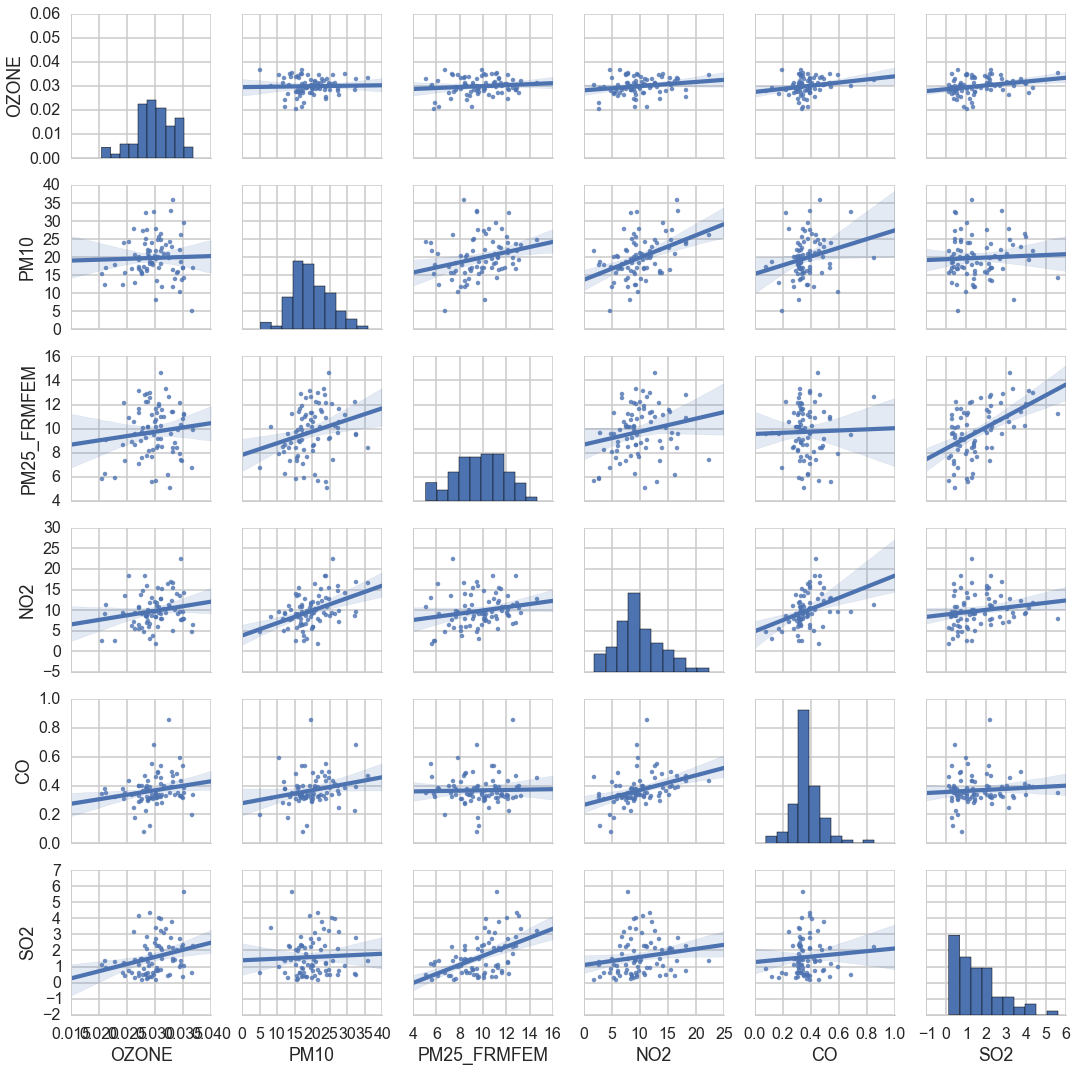

In [6]:
#Get correlations between each pair of pollutants
#list pollutants
pollutants = ['OZONE','PM10','PM25_FRMFEM','NO2','CO','SO2']
#loop through this list twice
#keeping track of the index of each loop
count1 = 0
for i in pollutants:
    count1 += 1
    count2 = 0
    for j in pollutants:
        count2 += 1
        #When the index of the second is bigger than the first,
        #we have a unique pair
        if j > i:
            #Get non-missing arguments for each pair
            index1 = []
            index2 = []
            for p,x in enumerate(pd.notnull(YearDat[[i]]).values):
                if x[0]:
                    index1.append(p)
            for p,x in enumerate(pd.notnull(YearDat[[j]]).values):
                if x[0]:
                    index2.append(p)
            touse = list(set(index2).intersection(index1))
            #Subset the dataset to just non-missing data
            a = YearDat[[i,j]]
            a = a.loc[touse]
            #Get correlation and print info
            print 'Correlation Between '+i+' and '+j+": " +str(sp.stats.pearsonr(a[i],a[j])[0])+" (p="+str(sp.stats.pearsonr(a[i],a[j])[1])+")"
#Make a pairplot
myplot = sns.pairplot(YearDat[['OZONE','PM10','PM25_FRMFEM','NO2','CO','SO2']].dropna(),kind='reg')

The distributions of each pollutant reflects well what we were seeing in the violin plots. Most things are fairly symmetrically distributed with the exception of $SO_2$ which has long tails. We definitely are seeing a range of variation across the different metrics which will make them interesting for modeling purposes.

Some pollutants appear more correlated than others. $NO_2$ and $CO$ have a highly significant correlation of about 0.44 (p<0.01). $NO_2$ also seems fairly correlated with PM2.5 and and PM10 (r=0.30 and r=0.36, p<0.01). This suggests that perhaps three variables share similar trends and maybe have similar causes. Other pollutants are not nearly as correlated though suggesting different sources of pollution. This gives us an idea of how well we can potentially develop 'pollutant profiles' based on differences in these pollutants.

##Visualizing Prediction Data

Now that we have a pretty good idea of what our pollutant data looks like and how each pollutant relates to one another, we can move forward and look at our predictors. We want to get a sense of what this data looks like before trying to build any models that relate the two together.

###Weather Data
Starting with the weather data we pretty much see the expected trends at the monthly level.

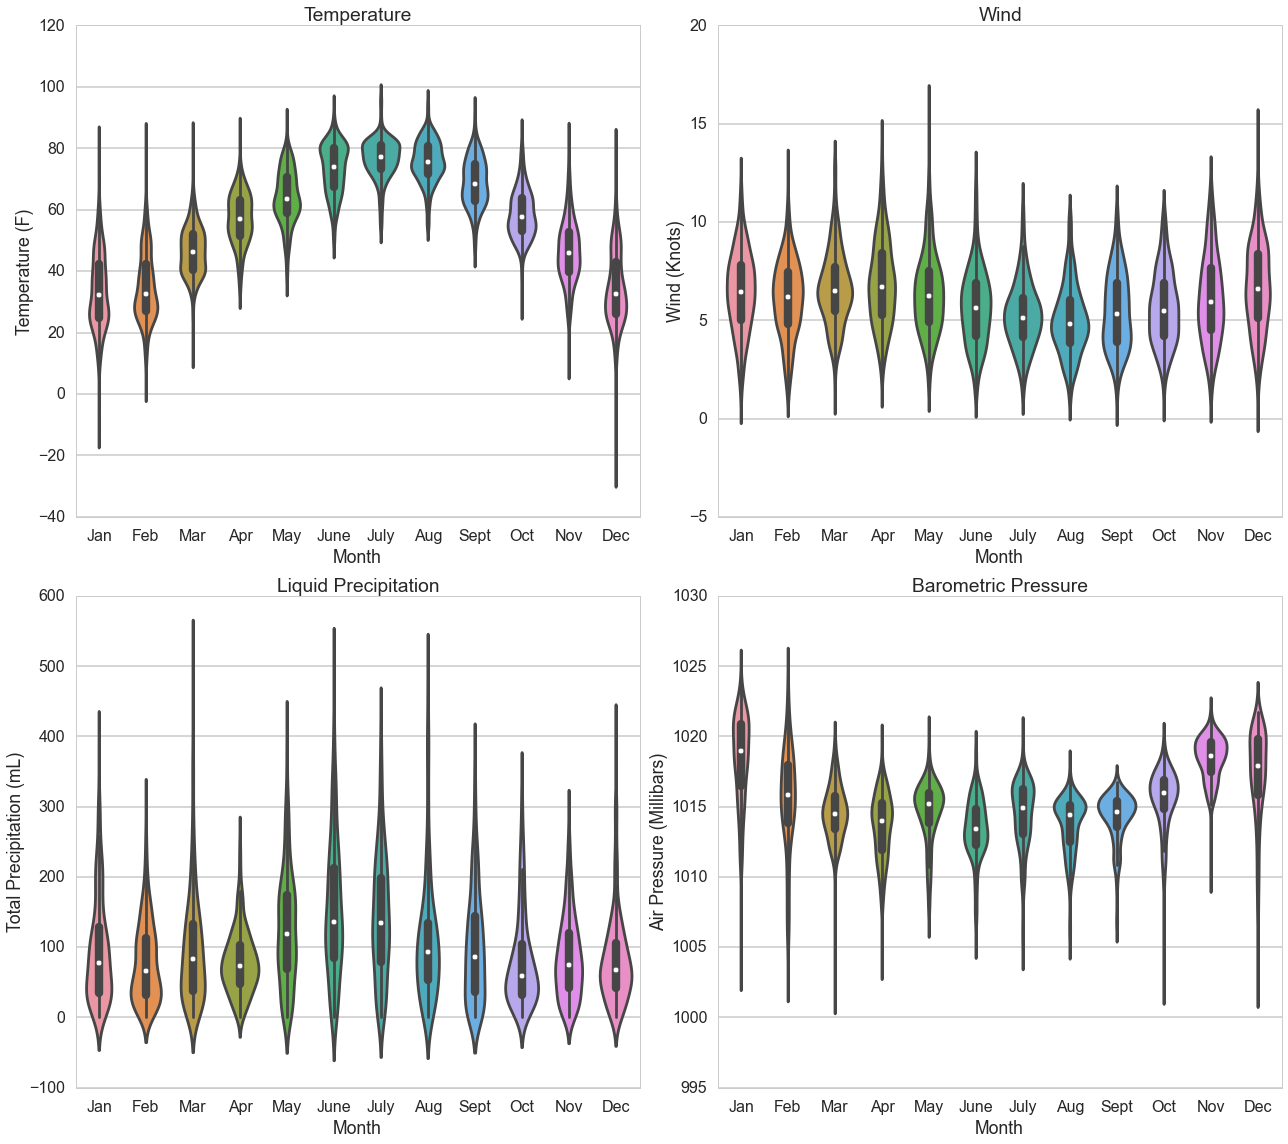

In [7]:
#Violin plots of weather data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 16))
fig.set_tight_layout(True)
sns.violinplot(x='Month',y='Temp',data=MonthDatMapped, ax = axes[0,0])
axes[0,0].set_title('Temperature')
axes[0,0].set_ylabel('Temperature (F)')
sns.violinplot(x='Month',y='Wind',data=MonthDatMapped, ax = axes[0,1])
axes[0,1].set_title('Wind')
axes[0,1].set_ylabel('Wind (Knots)')
sns.violinplot(x='Month',y='Precip',data=MonthDatMapped, ax = axes[1,0])
axes[1,0].set_title('Liquid Precipitation')
axes[1,0].set_ylabel('Total Precipitation (mL)')
sns.violinplot(x='Month',y='Pressure',data=MonthDatMapped, ax = axes[1,1])
axes[1,1].set_title('Barometric Pressure')
axes[1,1].set_ylabel('Air Pressure (Millibars)')

Temperature has the obvious seasonal patterns of higher temperature in the summer and lower temperatures in the winter. Pressure seems a bit lower in the summer months and liquid precipitation seems to increase a bit over the spring and early summer, but with a pretty large range.

The variation in the data does seem to have some seasonality for wind and precipitation. We see some very different levels of rain in difference seasons where there are much greater ranges in some months than others. A fun fact: the outlier in liquid precipitation for March is actually the Boston area that received nearly 20 inches of rain in the March of 2010. It was quite the flooding problem. 

As an overall conclusion, it's probably a bit too coarse to look just at an overall year and monthly/seasonal trends should probably be accounted for to some extent rather than just taking an overall yearly mean.

###Demographics and Traffic Data

We can visualize the demographic information using basic histograms. First, we see that most of our areas are metropolitan statistical areas based on the distribution below.

[<matplotlib.text.Text at 0x21405fd0>, <matplotlib.text.Text at 0x23318e48>]

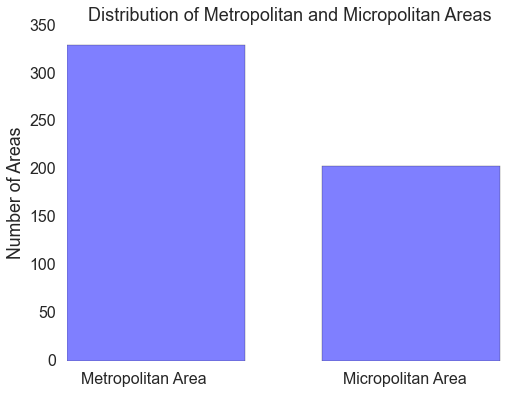

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar([0,.4],[YearDat['MetArea'].value_counts()[0],YearDat['MetArea'].value_counts()[1]], .28, color='b',alpha=0.5)
ax.grid('off')
#http://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# add some text for labels, title and axes ticks
ax.set_ylabel('Number of Areas')
ax.set_title('Distribution of Metropolitan and Micropolitan Areas',fontsize=18)
ax.set_xticks([.12,.53])
ax.set_xticklabels( ('Metropolitan Area', 'Micropolitan Area') )

Next, we see that the demographics vary quite a bit across our sites in terms of total population, area, and population density.

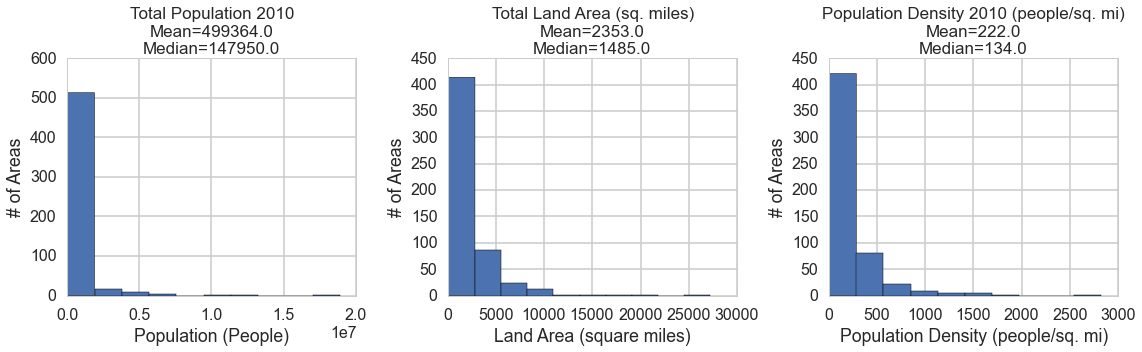

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
fig.set_tight_layout(True)
titlemap = {'pop2010':'Total Population 2010','landarea':'Total Land Area (sq. miles)','popdense2010':'Population Density 2010 (people/sq. mi)'}
xmap = {'pop2010':'Population (People)','landarea':'Land Area (square miles)','popdense2010':'Population Density (people/sq. mi)'}
a=np.array(YearDat[pd.notnull(YearDat['pop2010'])]['pop2010'])
for i,j in zip(axes.ravel(),['pop2010','landarea','popdense2010']):
    i.hist(YearDat[pd.notnull(YearDat[j])][j])
    i.set_title(titlemap[j]+'\nMean='+str(round(YearDat[pd.notnull(YearDat[j])][j].mean(),0))
                +'\nMedian='+str(round(YearDat[pd.notnull(YearDat[j])][j].median(),0)),fontsize=17)
    i.set_ylabel('# of Areas')
    i.set_xlabel(xmap[j])

We see that most demographics are heavily skewed as there are a few regions (like NYC) that are much larger in people and density. The population median is about 150,000 people, the land area median is about 1500 sq. miles, and the median density is about 133 peope/square mile.

For visualizing the mode of commuting, it is really easy to see this using a map. The following code generates a dataframe that allows us to make the next visualization.

In [10]:
TransitMode = YearDat[['CBSA Name','alone_frac','carpool_frac','other_frac','pt_frac','total_trans']]
TransitMode.dropna(inplace=True)
TransitMode['car_frac']=TransitMode['alone_frac']+TransitMode['carpool_frac']

C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
TransitMode['alone_frac']=TransitMode['alone_frac'].apply(lambda x: round(x,3))
TransitMode['pt_frac']=TransitMode['pt_frac'].apply(lambda x: round(x,3))
TransitMode['carpool_frac']=TransitMode['carpool_frac'].apply(lambda x: round(x,3))
TransitMode['car_frac']=TransitMode['car_frac'].apply(lambda x: round(x,3))
TransitMode['other_frac']=TransitMode['other_frac'].apply(lambda x: round(x,3))

C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the t

In [12]:
newFrame = {}
newFrame['CBSA Name'] = []
newFrame['Mode'] = []
newFrame['Total'] = []
for i in range(TransitMode.shape[0]):
    newFrame['CBSA Name'] = newFrame['CBSA Name'] + [TransitMode.iloc[i]['CBSA Name']]*100
    newFrame['Total'] = newFrame['Total']+[TransitMode.iloc[i]['total_trans']]*100
    newFrame['Mode'] = newFrame['Mode']+int("%.0f" % (TransitMode.iloc[i]['carpool_frac']*100))*['Carpool']+int("%.0f" % (TransitMode.iloc[i]['other_frac']*100))*['Other']+int("%.0f" % (TransitMode.iloc[i]['pt_frac']*100))*['Public Transportation']+int("%.0f" % (TransitMode.iloc[i]['alone_frac']*100))*['Drive Alone']
    if int("%.0f" % (TransitMode.iloc[i]['alone_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['other_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['carpool_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['pt_frac']*100)) >100:
        del newFrame['Mode'][-1]
    if int("%.0f" % (TransitMode.iloc[i]['alone_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['other_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['carpool_frac']*100)) + int("%.0f" % (TransitMode.iloc[i]['pt_frac']*100)) <100:
        newFrame['Mode'].append('Drive Alone')
pd.DataFrame(newFrame).to_csv('us_transit_to_tableu.csv')

Using Tableau, we can visualize the population density by CBSA as well as the preferred mode of transportation based on the file saved above: 

<img src='TransitMap.png' style="width:1200px; display:inline-block;">

The predominant mode of transportation appears to be driving alone by far -- pies are dominated by the blue componenet. There are a few metropolitan areas that have substantial use of public transit, such as the NYC area, the Boston area, the Bay Area, and the Chicago area. In general though, there isn't a vast amount of variation in transit style across sites.

##Basic relationship between predictors and outcomes

Now that we know what the outcome data (pollutants) and the predictor data (weather and demographics) looks like, we can see how the two relate to one another. This can help us determine which features we may want to include in models of the predictors.

C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


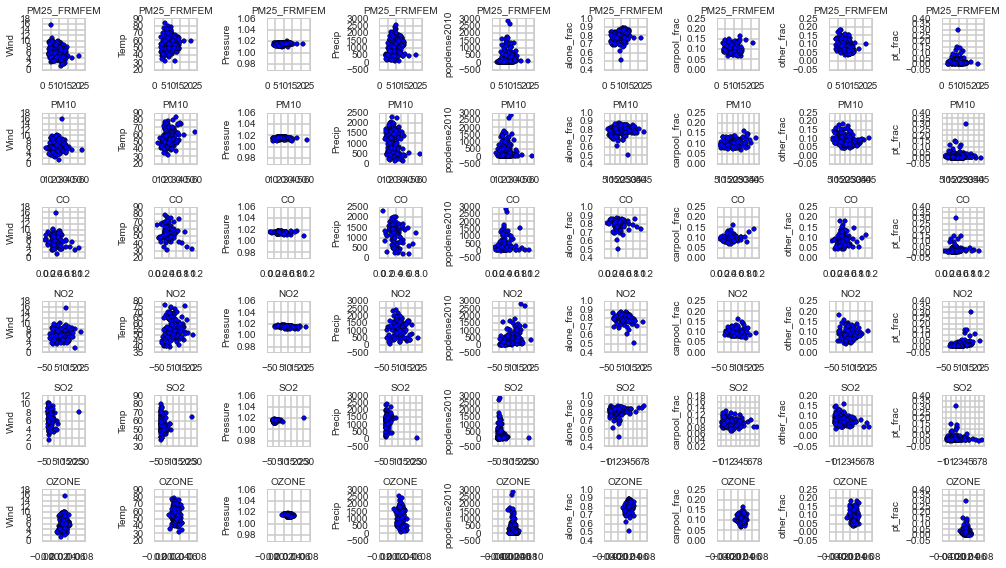

In [11]:
#Make a list of outcome variables and predictors
outcomes = ['PM25_FRMFEM',"PM10","CO","NO2",'SO2','OZONE']
predictors = ['Wind','Temp','Pressure','Precip','popdense2010','alone_frac','carpool_frac','other_frac','pt_frac']
#Initiate a grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=9, figsize=(14, 8), 
                         tight_layout=True)

count=0
#Loop through the pollutant and each predictor for that pollutant
for pol in outcomes:
    for pred in predictors:
        #If it's pressure, we scale the x-axis to better
        #fit in the plot
        ax = axes.ravel()[count]
        if pred == 'Pressure':
            plotting_dat = YearDat[[pol,pred]]
            plotting_dat[pred] = plotting_dat[pred]/1000 
        #Otherwise we just subset the data to the pollutant and predictor
        else:
            plotting_dat = YearDat[[pol,pred]]
        #Plot the scatterplot
        ax.scatter(plotting_dat[pol],plotting_dat[pred])
        #Fix some visual things
        count+=1
        ax.set_title(pol,fontsize=10)
        ax.set_ylabel(pred,fontsize=10)
        #Change tick fontsize based on help from
        #http://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(10)

Based on this plot, we don't see particularly strong correlations between the predictors and the pollutants. There are some possible trends - population density seems a it correlated with $NO_2$ which we'd expect. Wind seems a bit more correlated with PM10 than the other pollutants which we'd also expect.

It may be easier to visualize these relationships using a heatmap of a correlation matrix.

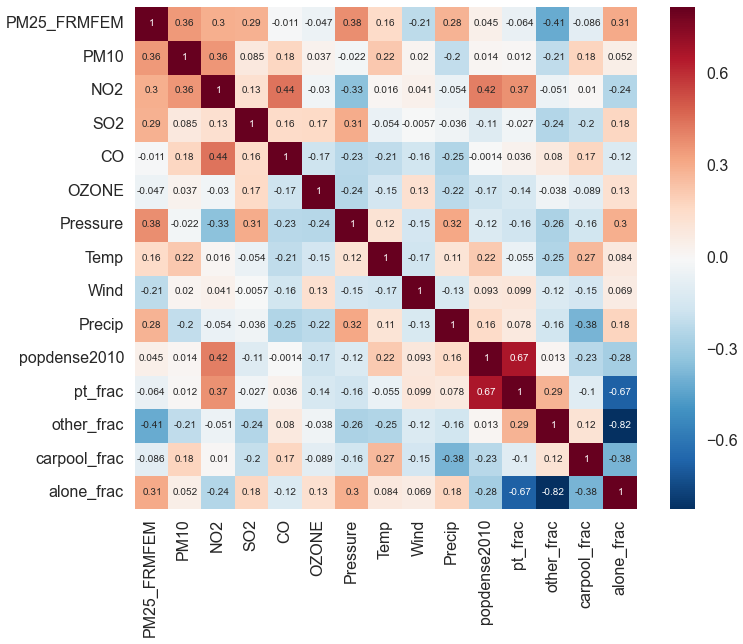

In [37]:
#Making a heatmap
#Help from http://stanford.edu/~mwaskom/software/seaborn/examples/network_correlations.html
df = YearDat[['PM25_FRMFEM','PM10','NO2','SO2','CO','OZONE','Pressure','Temp','Wind','Precip','popdense2010','pt_frac','other_frac','carpool_frac','alone_frac']]
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True,annot=True)

This better helps us visualize the relationships between our variables. Most of these make pretty good sense. There is a strong positive correlation between population density and the fraction of people using public transit -- we'd expect exactly that. There are more people who use public transit in a place with a larger population.

Of course, we're most interested in the relationship of the predictors with the pollutants. As we saw in the scatterplots, population density and the fraction of people using public transit is decently correlated with $NO_2$. This is to be expected as $NO_2$ is largely driven by car exhaust. PM2.5 seems to have a decent association with weather variables such as Temperature, Pressure, and Wind. It is also associated with the fraction of people commuting alone. This suggests that there may be both natural and anthropogenic sources of PM2.5. $SO_2$ seems to be associated with air pressure decently but not many other factors.

The other pollutants don't have particularly strong correlations with any of the other predictors in our dataset.